# Разработка системы распознавания предметов интерьера в потоковом видео

## Часть 1: Обзор датасета Ade20K

In [1]:
%matplotlib inline

#System
import os
import shutil
import random

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

#Keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPool2D, UpSampling2D
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

### Описание датасета с официального сайта

https://groups.csail.mit.edu/vision/datasets/ADE20K/

#### Изображение и маски

##### Images and annotations:

Each folder contains images separated by scene category (same scene categories than the Places Database). For each image, the object and part segmentations are stored in two different png files. All object and part instances are annotated sparately.

For each image there are the following files:

* .jpg: RGB image.
* _seg.png: object segmentation mask. This image contains information about the object class segmentation masks and also separates each class into instances. The channels R and G encode the objects class masks. The channel B encodes the instance object masks. The function loadAde20K.m extracts both masks.
* _seg_parts_N.png: parts segmentation mask, where N is a number (1,2,3,...) indicating the level in the part hierarchy. Parts are organized in a tree where objects are composed of parts, and parts can be composed of parts too, and parts of parts can have parts too. The level N indicates the depth in the part tree. Level N=1 corresponds to parts of objects. All the part segmentations have the same encoding as in the object segmentation masks, classes are coded in the RG channels and instances in the B channel. Use the function loadAde20K.m to extract part segmentation mask and to separate instances of the same class.
* _.txt: text file describing the content of each image (describing objects and parts). This information is redundant with other files. But in addition contains also information about object attributes. The function loadAde20K.m also parses the content of this file. Each line in the text file contains: column 1=instance number, column 2=part level (0 for objects), column 3=occluded (1 for true), column 4=class name (parsed using wordnet), column 5=original raw name (might provide a more detailed categorization), column 6=comma separated attributes list.

The following example has two part levels. The first segmentation shows the object masks. The second segmentation corresponds to object parts (body parts, mug parts, table parts, ...). The third segmentation shows parts of the heads (eyes, mouth, nose, ...):

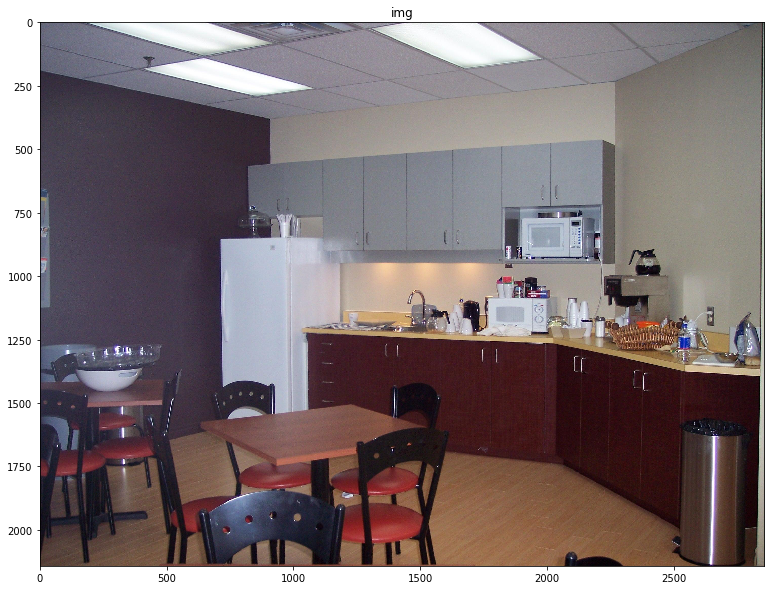

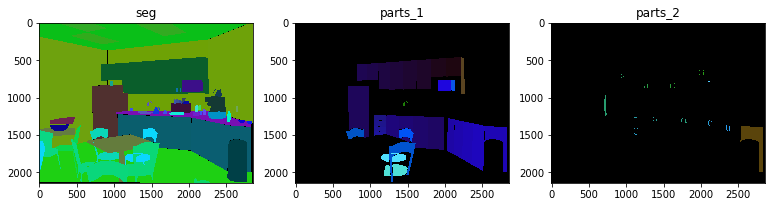

001 # 0 # 0 # wall # wall # ""
002 # 0 # 0 # wall # wall # ""
003 # 0 # 0 # wall # wall # ""
004 # 0 # 0 # floor, flooring # floor # "wood"
005 # 0 # 0 # ceiling # ceiling # ""
006 # 0 # 0 # light, light source # light troffer # "on"
007 # 0 # 0 # light, light source # light troffer # "on"
008 # 0 # 0 # light, light source # light troffer # "on"
009 # 0 # 0 # cabinet # cabinets # ""
010 # 0 # 0 # refrigerator, icebox # refrigerator # ""


In [2]:
dir_path = 'data/ADE20K_filtred/images/train/b/breakroom/'

plt.figure(figsize=(13, 10))
plt.imshow(plt.imread(dir_path + "ADE_train_00004520.jpg")), plt.title("img")
plt.show()

plt.figure(figsize=(13, 10))
plt.subplot(131), plt.imshow(plt.imread(dir_path + "ADE_train_00004520_seg.png")), plt.title("seg")
plt.subplot(132), plt.imshow(plt.imread(dir_path + "ADE_train_00004520_parts_1.png")), plt.title('parts_1')
plt.subplot(133), plt.imshow(plt.imread(dir_path + "ADE_train_00004520_parts_2.png")), plt.title('parts_2')
plt.show()


with open(dir_path + "ADE_train_00004520_atr.txt") as f:
    for line, count in zip(f, range(0, 10)):
        print(line, end="")

#### Описание изображения

Так же у каждой фотографии есть файл с описанием объектов на масках:

* column 1=instance number (номер экземпляра)
* column 2=part level (0 for objects) (уровень детали (0 для объектов))
* column 3=occluded (1 for true) (закрытый (другим предметом?) (1 для true))
* column 4=class name (parsed using wordnet) (класс (wordnet))
* column 5=original raw name (might provide a more detailed categorization) (исходное (сырое) имя)
* column 6=comma separated attributes list (список атрибутов)

In [3]:
with open(dir_path + "ADE_train_00004520_atr.txt") as f:
    for i, line in zip(range(5), f):
        print(line, end="")
print("...")

001 # 0 # 0 # wall # wall # ""
002 # 0 # 0 # wall # wall # ""
003 # 0 # 0 # wall # wall # ""
004 # 0 # 0 # floor, flooring # floor # "wood"
005 # 0 # 0 # ceiling # ceiling # ""
...


Напишем функцию для преобразования данных в этом файле в pandas.DataFrame

In [334]:
def get_seg_description(path):
    description = []
    with open(path) as f:
        for line in f:
            (instance_n, part_level, occluded,
            class_name, original_name, attributes_list) = line.rstrip().split(" # ")
            description.append([int(instance_n), int(part_level), occluded == "1", 
                               class_name, original_name, attributes_list.strip("\"")])
    description = pd.DataFrame(description).rename(columns={0: "instance_n", 1: "part_level", 2: "occluded", 
                                                          3: "class_name", 4: "original_name", 5: "attributes" })
    return description

get_seg_description(dir_path + "ADE_train_00004520_atr.txt").head()

,instance_n,part_level,occluded,class_name,original_name,attributes
0,1,0,False,wall,wall,
1,2,0,False,wall,wall,
2,3,0,False,wall,wall,
3,4,0,False,"floor, flooring",floor,wood
4,5,0,False,ceiling,ceiling,


### Наименования

Посмотрим на то, как имянуются файлы в папках

In [338]:
for i, file in zip(range(10), sorted(os.listdir('data/ADE20K_filtred/images/train/v/veranda/'))):
    print(file)

ADE_train_00019501.jpg
ADE_train_00019501_atr.txt
ADE_train_00019501_seg.png
ADE_train_00019502.jpg
ADE_train_00019502_atr.txt
ADE_train_00019502_seg.png
ADE_train_00019503.jpg
ADE_train_00019503_atr.txt
ADE_train_00019503_seg.png
ADE_train_00019504.jpg


#### Функция для более удобной работы

Напишем функцию для преобразования имени файлов для более удобной работы с ними.
Возвращаемые значения:
* имя (номер) фотографии
* описание: img, seg, parts, text
* валидационный класс: train, val
* номер части: (число) для файлов parts, 0 для остальных

In [339]:
def get_format(file_name):
    name_split = file_name.split("_")
    file_format = name_split[0:-1] + name_split[-1].split(".")
    ade, train_or_val, name = file_format[:3]
    extension = file_format[-1]
    
    description = 0
    parts_num = 0
    if extension == 'jpg':
        description = 'img'
    elif extension == 'txt':
        description = 'text'
    else: #png
        description = file_format[3]
        if file_format[4].isdigit():
            parts_num = int(file_format[4])
    return [name, description, train_or_val, parts_num]

for i, file in zip(range(10), sorted(os.listdir('data/ADE20K_filtred/images/train/v/veranda/'))):
    print(str(get_format(file)))

['00019501', 'img', 'train', 0]
['00019501', 'text', 'train', 0]
['00019501', 'seg', 'train', 0]
['00019502', 'img', 'train', 0]
['00019502', 'text', 'train', 0]
['00019502', 'seg', 'train', 0]
['00019503', 'img', 'train', 0]
['00019503', 'text', 'train', 0]
['00019503', 'seg', 'train', 0]
['00019504', 'img', 'train', 0]


### Размер обучающей выборки

Напишем функцию для определения количества уникальных изображений в папке и её подпапках

In [287]:
def get_dataset_size(dir_path):
    dataset_size = 0
    for path, dirs, files in os.walk(dir_path):
        if files:
            for file in files:
                name, description, train_or_val, parts_num = get_format(file)
                if description == 'img':
                    dataset_size += 1
    return dataset_size

#### Исходная выборка

Посмотрим размер исходной обучающей выборки

In [288]:
get_dataset_size('data/ADE20K_original/images/')

22210

#### Фильтрованная выборка

Исходная обучающая выборка состоит из всевозможных обучающих изображений. Не все из них нам подходят - так им образом после ручной фильтрации изображений остались только подходящие нам (фотографии интерьера).

In [290]:
get_dataset_size('data/ADE20K_filtred/images/train/')

8728

#### Дополнительные нетематические данные

Так же в фильтрованной выборке есть дополнительные данные, которые не были распределены по тематическим папкам и содержат как подходящие нам изображение, так и нет. Пока оставим эти данные.

In [291]:
get_dataset_size('data/ADE20K_filtred/images/extra/')

1667

### Распределение размерности

Для определения входа обучения алгоритмов посмотрим на распределение размерностей фотографий.

Напишем функцию, генерирующую массив размерностей фотографий

In [302]:
%%time
def get_shape_arr(dir_path):
    shape_arr = []
    for path, dirs, files in os.walk(dir_path):
        if files:
            for file in files:
                name, description, train_or_val, parts_num = get_format(file)
                if description == 'img':
                    img = imread(path + '/' + file)
                    shape_arr.append(img.shape[:2])
    shape_arr = np.array(shape_arr)
    return shape_arr

shape_arr = get_shape_arr('data/ADE20K_filtred/images/train/')

Построим распределение размерностей

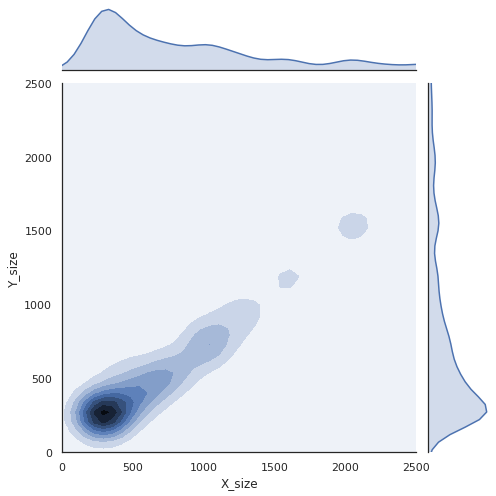

In [312]:
g = sns.jointplot(x=1, y=0, data=pd.DataFrame(shape_arr), kind="kde", 
                  color='b', xlim=(0, 2500), ylim=(0, 2500), height=7)
g.set_axis_labels("X_size", "Y_size")

plt.show()

Получаем, что подавляющее большинство фотографий имеет размер до 750*750 пикселей

### Декодирование информации из масок

Расмотрим подробнее часть маски фотографии

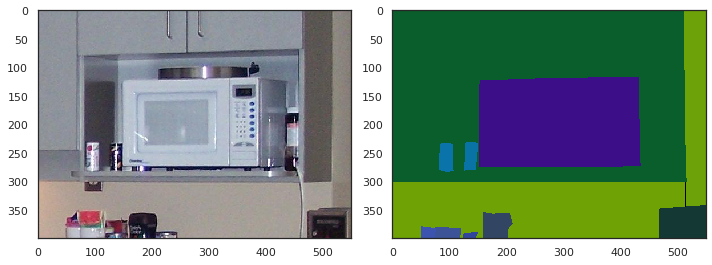

In [359]:
seg = imread(dir_path + "ADE_train_00004520_seg.png")
img = imread(dir_path + "ADE_train_00004520.jpg")

plt.figure(figsize=(10, 10))
plt.subplot(121), imshow(img[650:1050, 1750:2300])
plt.subplot(122), imshow(seg[650:1050, 1750:2300])
plt.show()

Попробуем восстановить, к какому классу объектов принадлежит выделенная область на маске.

#### Описание масок

Из описания датасета известно, что у нас есть описание содержимого на масках. Например, выведем описание маски первого уровня (seg)

In [360]:
description[description.part_level == 0].head()

,instance_n,part_level,occluded,class_name,original_name,attributes
0,1,0,False,wall,wall,
1,2,0,False,wall,wall,
2,3,0,False,wall,wall,
3,4,0,False,"floor, flooring",floor,wood
4,5,0,False,ceiling,ceiling,


Как мы видим, это описание лишь даёт представление о наличие объекта на фотографии, но не даёт информации о его расположении.

#### Закодированные значения масок

В описании датасета сказано, что каналы RG кодируют информацию об принадлежности объекта к классу. Но, к сожалению, в описании явно не сказано, как декодировать значения этих данных и получить класс объекта. Попробуем разобраться сами.

В оригинальном датасете присутствует файл `index_ade20k_2015.mat` c описанием датасета.
Это файл-структура для Matlab и содержит разнообразные поля. Добавлю описание этого файла с официального сайта.

##### Matlab file: index_ade20k_2015.mat

* filename: cell array of length N=22210 with the image file names.
* folder: cell array of length N with the image folder names.
* scene: cell array of length N providing the scene name (same classes as the Places database) for each image.
* objectnames: cell array of length C with the object class names.
* wordnet_found: array of length C. It indicates if the objectname was found in Wordnet.
* wordnet_hypernym: cell array of length C. WordNet hypernyms for each object name.
* wordnet_gloss: cell array of length C. WordNet definition.
* objectcounts: array of length C with the number of instances for each object class.
* objectPresence: array of size [length C, N] with the object counts per image. objectPresence(c,i)=n if in image i there are n instances of object class c.
* objectIsPart: array of size [length C, N] counting how many times an object is a part in each image. objectIsPart(c,i)=m if in image i object class c is a part of another object m times. For objects, objectIsPart(c,i)=0, and for parts we will find: objectIsPart(c,i) ≈ objectPresence(c,i).
* proportionClassIsPart: array of length C with the proportion of times that class c behaves as a part. If proportionClassIsPart(c)=0 then it means that this is a main object (e.g., car, chair, ...). See bellow for a discussion on the utility of this variable.

Нас интересует поле `objectnames`, которое содержит всевозможные классы объектов на всех фотографиях.

Распарсим это поле и перенесём значения в отдельный файл `objectnames.txt`

Осталось понять, как найти отображение из значений пикселей в класс.

Из исходного кода скрипта `loadAde20K.m` набора Matlab Tools получаем точное отображение:
$index = \frac{R}{10} * 256 + G$

Напишем класс для декодирования пикселей

In [9]:
class SegEncoder:
    def __init__(self, objectnames_path):
        with open(objectnames_path, 'r') as f:
            self.obj_names = f.readline().split("\t")
        self.obj_names = list(map(lambda name: name.strip("\'"), self.obj_names))
    
    def get_class_index(self, pixel):
        R = pixel[0]
        G = pixel[1]
        B = pixel[2]
        return int(R / 10 * 256 + G)
    
    def get_class(self, pixel):
        return self.obj_names[self.get_class_index(pixel) - 1]
    
segEncoder = SegEncoder('data/ADE20K_filtred/objectnames.txt')

Проверим работу

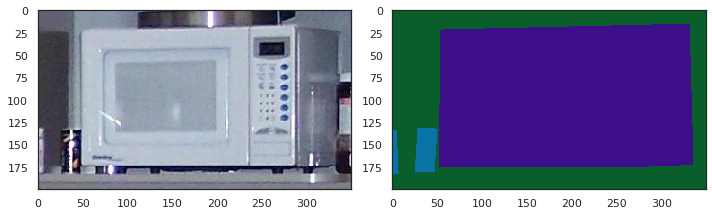

'microwave, microwave oven'

In [10]:
seg = imread(dir_path + "ADE_train_00004520_seg.png")
img = imread(dir_path + "ADE_train_00004520.jpg")

plt.figure(figsize=(10, 10))
plt.subplot(121), imshow(img[750:950, 1850:2200])
plt.subplot(122), imshow(seg[750:950, 1850:2200])
plt.show()

segEncoder.get_class(seg[850, 2000])